# Finding Optimal Locations for Dark Stores for quick commerce

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from tqdm import tqdm
import re

In [5]:
np.random.seed(0)

# uniformly distributed points
points=100*np.random.random((200, 2))



## Setting up locations of customers on a map with areas of uniform traffic level

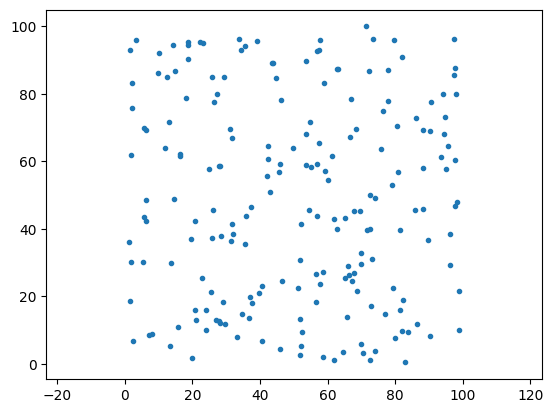

In [6]:

points_t=points.T
plt.plot(points_t[0], points_t[1], '.');

plt.axis('equal')
plt.show()

## Defining distance and travel time functions

In [31]:
k=20# maximum distance 'k'

def dist(point1, point2):
    distance=((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)**0.5
    return distance



## Main part of the code, including the optimization function

In [32]:
def add_origin(route, points, radius=k):
    origin = route[0] # the origin for every iteration has been added to the front of the list,
                      # so it is being extracted here
    new_path = [origin] # origin is the first location of the new_path
    route = route[1:]
    route_time = 0 # initial time for route of first delivery man

    while len(route) > 0: # while there are still places left on the map to deliver to
        
        point_time=dist(points[new_path[-1]], points[route[0]]) # distance of next point from last point in new route
        route_time +=point_time # path time

        if route_time > radius:
            new_path.append(origin) # start new delivery man
            route_time = 0
        else:
            new_path.append(route[0])
            route = route[1:]

    new_path.append(origin)
    return new_path


In [33]:
def two_opt(route, points):
    n = len(route) 
    improvement = True

    while improvement:
        improvement = False
        for i in range(1, n - 2):
            for j in range(i + 1, n):
                new_route = route.copy()
                new_route[i:j] = route[j - 1 : i - 1 : -1]
                new_distance = calculate_distance(new_route, points) 
                # here the new_distance is calculated
                # this invokes the calculate_distance function, which in turn invokes the add_origin function
                # while calculating the distance. hence the total path length is optimized, including return 
                # visits to the origin, when the journey length is greater than 'k' kms.

                if new_distance < calculate_distance(route, points): 
                    # both the new and old distances take origin visits into account
                    route = new_route
                    improvement = True

        return route

    
def calculate_distance(route, points, go_origin=True): 
    # the go_origin parameter dictates whether we invoke the add_origin function or not
    # we will not invoke it only in the case where we have to find the total path length, since origin visits are
    # already included as part of the final path.
    route_time = 0
    if go_origin==True:
        route=add_origin(route, points)
    n = len(route)

    for i in range(n - 1):
        route_time += dist(points[route[i]], points[route[i+1]])
    route_time += dist(points[route[n-1]], points[route[0]]) 

    return route_time

## Defining function for points within reachable areas, and maximum deliveries

In [34]:
def points_in_radius(points, origin, radius=k): # function to find the points within 'k' minutes from origin
    in_radius=[]
    for i in points:
        if dist(origin, i)<=radius:
            in_radius.append(list(i))
    return (in_radius)

def total_deliveries(optimized_route, points, n=5):
    deliveries=[]
    new_delivery=[]
    for i in optimized_route[1:]:
        if i==0:
            deliveries.append([len(new_delivery), new_delivery])
            new_delivery=[]
        else:
            new_delivery.append(i)
            
    dels=sorted(deliveries)[::-1][:n]
    
    total_dels=0
    final_path=[0]
    for i in dels:
        final_path+=i[1]+[0]
        total_dels+=i[0]
    
    return points[final_path], calculate_distance(final_path, points, go_origin=False), total_dels


## Dummy run for the code

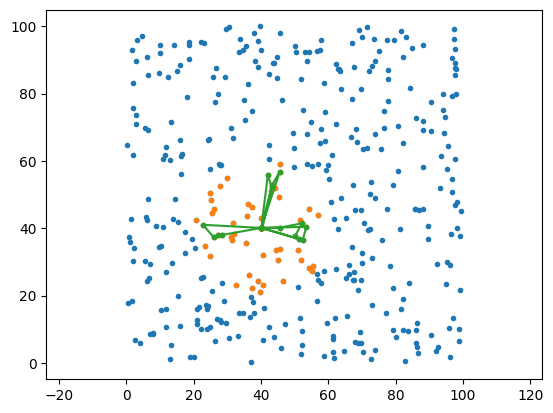

In [35]:
origin=np.array([40.1,40.1])
p= np.array([origin]+points_in_radius(points, origin))
initial_route = [i for i in range(len(p))]

optimized_route = add_origin(two_opt(initial_route, p), p)
pt=p[optimized_route]

path_final, time, dels=total_deliveries(optimized_route, p, n=5)
plt.plot(points_t[0], points_t[1], '.');
plt.plot(pt.T[0], pt.T[1], '.');
plt.plot(path_final.T[0], path_final.T[1], '.-');
# plt.plot(90.1, 90.1,'o');

circle2 = plt.Circle((50, 50), 50, fill=False, color='orange')
circle1 = plt.Circle((50, 50), 25, fill=False, color='red')
# plt.gca().add_patch(circle1)
# plt.gca().add_patch(circle2)


plt.axis('equal')
plt.show()

## Function for running the code on a full map

In [36]:
def find_location( points, grid_divisions, grid):
    customers={}

    h0,k0,l0=grid # centre of grid and length of grid

    for i in tqdm(range(grid_divisions+1)):
        for j in range(grid_divisions+1):
            origin=np.array([i* l0/grid_divisions + h0-l0/2 +(0.1**5) , j* l0/grid_divisions + k0-l0/2 +(0.1**5)])
            zone= np.array([origin]+points_in_radius(points, origin))

            initial_route = [i for i in range(len(zone))]

            optimized_route = add_origin(two_opt(initial_route, zone), zone)
            pt, path_time, total_dels=total_deliveries(optimized_route, zone, n=5)
            customers[str([origin[0],origin[1]])]=[total_dels, -path_time]

    return customers



## Main function 

In [37]:
def traversal(points):

    locations = find_location( points, 10, [50,50,100])
    locations = sorted(locations, key=locations.get)[::-1]
    
    top_4_locations=[]
    for key in locations:
        if len(top_4_locations)==2:
            break
        top_4_locations.append([float(i) for i in key[1:-1].split(',')])

    final_locs={}
    for i in top_4_locations:
        locations=find_location( points, 5, [i[0],i[1],20])
        final_locs.update(locations)

    warehouse_location=max(zip(final_locs.values(), final_locs.keys()))[1]
    warehouse_location=np.array([float(i)+0.1**5 for i in warehouse_location[1:-1].split(',')])

    zone= np.array([warehouse_location]+points_in_radius(points, warehouse_location))

    initial_route = [i for i in range(len(zone))]

    optimized_route = add_origin(two_opt(initial_route, zone), zone)
    pt, path_time, total_dels=total_deliveries(optimized_route, zone, n=5)
    

    
    return warehouse_location, pt

In [38]:
import time


In [51]:

# 100
np.random.seed(7)
points=100*np.random.random((100, 2))

t1=time.time()
warehouse_location1, customers1 = traversal(points)
print(time.time()-t1)

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 30.50it/s]


0.9465258121490479


In [45]:
# 200
np.random.seed(4)
points=100*np.random.random((200, 2))

t1=time.time()
warehouse_location1, customers1 = traversal(points)
print(time.time()-t1)

100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.05it/s]

6.607539176940918


In [42]:

# 400
np.random.seed(1)
points=100*np.random.random((400, 2))

t1=time.time()
warehouse_location1, customers1 = traversal(points)
print(time.time()-t1)

100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.78s/it]


33.69085383415222


In [56]:

list_of_points=set(tuple(i) for i in points)
points_to_remove = set(tuple(i) for i in customers1)
remaining_points = [point for point in list_of_points if point not in points_to_remove]
remaining_points = np.array(remaining_points)


In [57]:
warehouse_location2, customers2 = traversal( remaining_points)


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 46.51it/s]


In [58]:
list_of_points=set(tuple(i) for i in remaining_points)
points_to_remove = set(tuple(i) for i in customers2)
remaining_points2 = [point for point in list_of_points if point not in points_to_remove]
remaining_points2 = np.array(remaining_points2)


In [59]:
warehouse_location3, customers3 = traversal( remaining_points2)


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 61.03it/s]


In [60]:
list_of_points=set(tuple(i) for i in remaining_points2)
points_to_remove = set(tuple(i) for i in customers3)
remaining_points3 = [point for point in list_of_points if point not in points_to_remove]
remaining_points3 = np.array(remaining_points3)


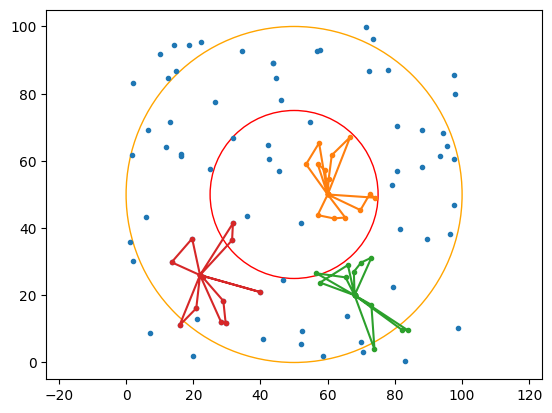

In [61]:
plt.plot(remaining_points2.T[0], remaining_points2.T[1], '.');
# plt.plot(points.T[0], points.T[1], '.');
plt.plot(customers1.T[0], customers1.T[1], '.-');
plt.plot(customers2.T[0], customers2.T[1], '.-');
plt.plot(customers3.T[0], customers3.T[1], '.-');


circle2 = plt.Circle((50, 50), 50, fill=False, color='orange')
circle1 = plt.Circle((50, 50), 25, fill=False, color='red')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)


plt.axis('equal')
plt.show()

In [1]:
# case 1 : constant travel times

In [2]:
# case 2 : different travel times

In [3]:
# case 3 : different travel times with gaussian dist